In [12]:
import folium
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

from matplotlib import font_manager,rc
from sklearn.preprocessing import MaxAbsScaler

warnings.filterwarnings(action='ignore')
matplotlib.rc('font',family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())

%matplotlib inline

In [2]:
palette = ['#eb9385', '#f5eedb', '#99c0bc', '#937782', '#2d4249']

---

# 코로나가 고령자에게 미치는 영향

<br />
<br />

내용..



<br />  

### **목차**
1. 연령대별 코로나 환자 수 확인
2. 연령대를 청년, 중년, 노년으로 분류 후 코로나로 인한 사망률 확인
3. 기저질환 여부가 코로나에 미치는 영향
4. 고령자의 고위험장소 분류

---

## 1. 연령대별 코로나 환자 수

고령자들의 코로나 감염 실태를 확인해보기 위해서 연령대별 코로나 환자 수를 확인해봤습니다.  
20대 코로나 환자가 가장 많았고, 30~60대도 20대보단 적지만 많은 수준입니다.   
그에비해 70-100대는 코로나 환자는 절반도 안 되어 비중이 적어보일 수 있겠지만, 노인인구비율을 보면 절대로 적은 수준은 아닙니다.

id 결측치 개수: 0
id 데이터 개수: 4004
id 유니크 개수: 4004
age 결측치 제거 전: 4004
age 결측치 개수: 479
age 결측치 제거 후: 3525
age 값: 
20     860
50     625
30     494
40     483
60     423
70     210
80     162
10     160
0       60
90      47
100      1
Name: age, dtype: int64


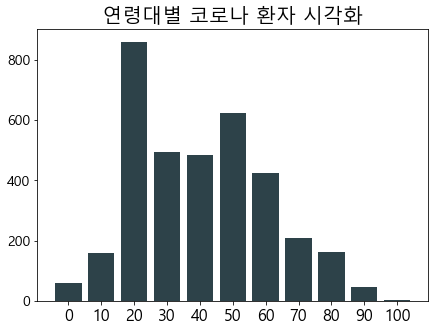

In [4]:
# 연령대별로 코로나 

patientInfo = pd.read_csv('./coronavirusdataset/PatientInfo.csv')
patientInfo

# 환자 아이디값에 중복치가 있는지 확인
print(f'id 결측치 개수: {patientInfo.patient_id.isna().sum()}')
print(f'id 데이터 개수: {patientInfo.patient_id.count()}')
print(f'id 유니크 개수: {len(patientInfo.patient_id.unique())}')

# 연령대 값에 결측치가 있는지 확인하고 제거
na = patientInfo.age.isna()
print(f'age 결측치 제거 전: {na.count()}')
ages = patientInfo.dropna(subset=['age'])
print(f'age 결측치 개수: {na.sum()}')
print(f'age 결측치 제거 후: {ages.age.isna().count()}')

# 연령대 전처리
ages['age'] = ages['age'].apply(lambda x: int(x.replace('s', '')))
print(f'age 값: \n{ages.age.value_counts()}')

# 
# ages = ages.sort_values(by=['age'], axis=0)
# ages = ages.reset_index()

# 연령대별 코로나 환자 시각화
index = range(len(ages.age.unique()))
count = ages.age.value_counts().sort_index()

plt.figure(figsize=(7, 5))
plt.bar(index, count, color=palette[4])
plt.xticks(index, count.index, fontsize=16)
plt.yticks(fontsize=14)
plt.title('연령대별 코로나 환자 시각화', fontsize=20)
plt.show()

## 2. 청년, 중년, 노년기별 코로나로 인한 사망률
각 연령대를 0-30세 까지는 청년, 40-60세 까진 중년, 70세 이상은 노년으로 분류한 다음, 세대별 확진자 중 사망한 사람의 비율을 구했습니다.


위의 연령별 코로나 확진자 수와 비교하여 확인해보면 청년층은 확진자 수가 많음에도 사망률이 0.095퍼센트로 0.1퍼센트조차 되지 않는 것에 비해 노년층 확진자는 청년층 확진자에 비해 많지 않음에도 사망 비율이 26.8퍼센트나 됩니다.


사망자 비율로 볼 땐 고령자에게 코로나 감염은 매우 치명적이라는 것을 확인할 수 있습니다.

In [5]:
# state 칼럼 결측치 확인
print(f'state 칼럼 결측치 확인: {ages.shape} / {ages.state.shape}')
# state 원 핫 인코딩
ages = pd.get_dummies(ages, columns = ['state'])

# 연령대를 구분하는 칼럼 추가
life_cycle = [-1, 35, 65, 125]
labels = ["청년", "중년", "노년"]
cats = pd.cut(ages.age.tolist(), life_cycle, labels=labels)
ages['group'] = cats

# 카테고리별 격리, 퇴원, 사맡자 수
state = ages.groupby('group')[['state_isolated', 'state_released', 'state_deceased']].sum()
state

state 칼럼 결측치 확인: (3525, 18) / (3525,)


,state_isolated,state_released,state_deceased
group,,,
청년,516.0,1057.0,1.0
중년,515.0,995.0,21.0
노년,174.0,194.0,52.0


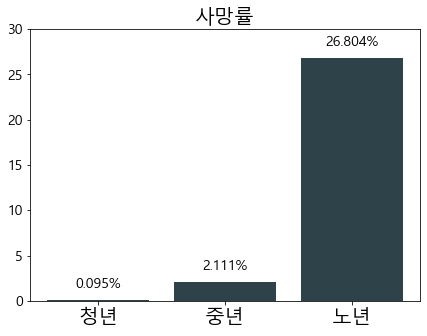

In [34]:
index = range(len(state.index))
count = [((y / x) * 100) for x, y in zip(state.state_released, state.state_deceased)]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
plt.bar(index, count, color=palette[4])
plt.xticks(index, labels, fontsize=20)
plt.yticks(fontsize=14)
plt.title('사망률', fontsize=20)
plt.ylim(0, 30)

for x, y in zip(index, count):
        ax.text(x, y+1, str(round(y, 3))+'%', ha='center', va='bottom', fontsize=14)

## 3. 기저질환 여부가 코로나에 미치는 영향

코로나로 인한 사망자들 중 다른 특징이 있는지 살펴보던 도중 기저질환이 있는 환자인지 수집해놓은 데이터가 있어서 기저질환 여부가 코로나에 영향을 미치는지 분석해보았습니다.


첫 번째 표를 보면 기저질환을 가진 환자의 연령대를 보면 전부 중년층-노년층에 분포해 있는 걸 확인할 수 있습니다.


따라서 청년층 데이터를 제외하고 중-노년층의 기저질환 여부가 코로나로 인한 사망에 영향을 끼치는지 분석해본 결과,
중-노년층의 전체 환자 중 기저질환을 가진 환자의 비율은 0.92퍼센트 정도 되었고, 이 중 기저질환이 있는 환자의 사망률을 구했을 때 사망률이 100퍼센트가 나왔습니다.  


하지만 기저질환이 없는 환자의 사망률은 2.85퍼센트인 것을 보면 기저질환이 있는 환자 또한 코로나 감염이 굉장히 치명적이라는 것을 알 수 있습니다.

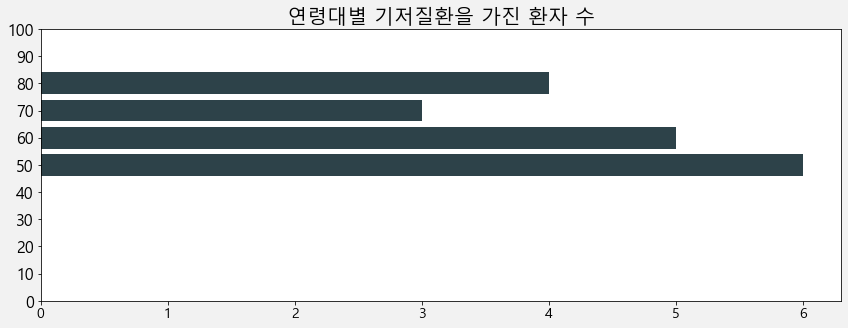

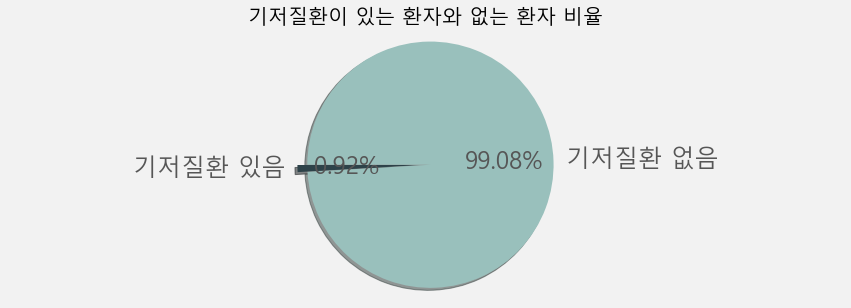

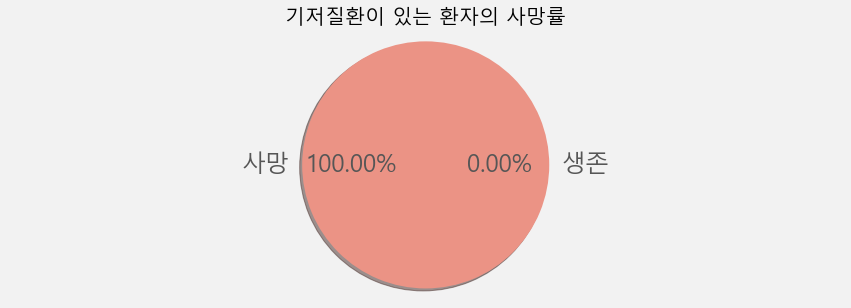

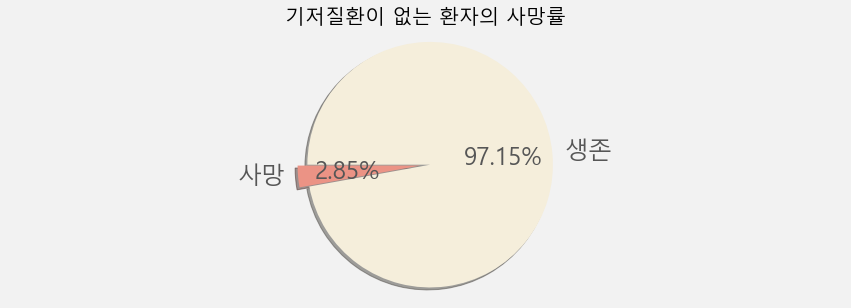

In [39]:
disease_true = ages[(ages.group != '청년') & (ages.disease == True)]
disease_false = ages[(ages.group != '청년') & (ages.disease.isna())]

# 기저질환보유자 연령대 시각화
index = range(0, 100+1, 10)
count = disease_true.age.value_counts().sort_index()
fig = plt.figure(figsize=(14.35, 5))
plt.barh(count.index, count, color=palette[4], align='center', height=8)
plt.yticks(index, index, fontsize=16)
plt.xticks(fontsize=14)
plt.title('연령대별 기저질환을 가진 환자 수', fontsize=20)
ax = fig
ax.set_facecolor('#f2f2f2')
plt.show()

# 기저질환을 가지고있는 환자와 없는 환자의 비율 시각화
disease_patient_ratio = [
    disease_true.patient_id.count(),
    disease_false.patient_id.count()
]
fig = plt.figure(figsize=(15, 5))
plt.pie(disease_patient_ratio,
        labels=['기저질환 있음', '기저질환 없음'], 
        colors=[palette[4], palette[2]], 
        autopct='%1.2f%%',
        shadow=True, 
        startangle=180,
        explode=(0.08, 0),
        textprops={'fontsize': 24, 'color': '#565656'})
plt.axis('equal')
plt.title('기저질환이 있는 환자와 없는 환자 비율', fontsize=20)
ax = fig
ax.set_facecolor('#f2f2f2')
plt.show()

# 기저질환을 가지고 있는 환자의 사망률 시각화
disease_true_ratio = [
    disease_true[disease_true.state_deceased == 1]['state_deceased'].count(), 
    disease_true[disease_true.state_deceased == 0]['state_deceased'].count()
]
fig = plt.figure(figsize=(15, 5))
plt.pie(disease_true_ratio,
        labels=['사망', '생존'], 
        colors=[palette[0], palette[1]], 
        autopct='%1.2f%%',
        shadow=True, 
        textprops={'fontsize': 24, 'color': '#565656'})
plt.axis('equal')
plt.title('기저질환이 있는 환자의 사망률', fontsize=20)
ax = fig
ax.set_facecolor('#f2f2f2')
plt.show()

# 기저질환을 가지고 있지 않은 환자의 사망률 시각화
disease_false_ratio = [
    disease_false[disease_false.state_deceased == 1]['state_deceased'].count(), 
    disease_false[disease_false.state_deceased == 0]['state_deceased'].count()
]
fig = plt.figure(figsize=(15, 5))
plt.pie(disease_false_ratio,
        labels=['사망', '생존'], 
        colors=[palette[0], palette[1]], 
        autopct='%1.2f%%',
        shadow=True, 
        startangle=180,
        explode=(0.08, 0),
        textprops={'fontsize': 24, 'color': '#565656'})
plt.axis('equal')
plt.title('기저질환이 없는 환자의 사망률', fontsize=20)
ax = fig
ax.set_facecolor('#f2f2f2')
plt.show()

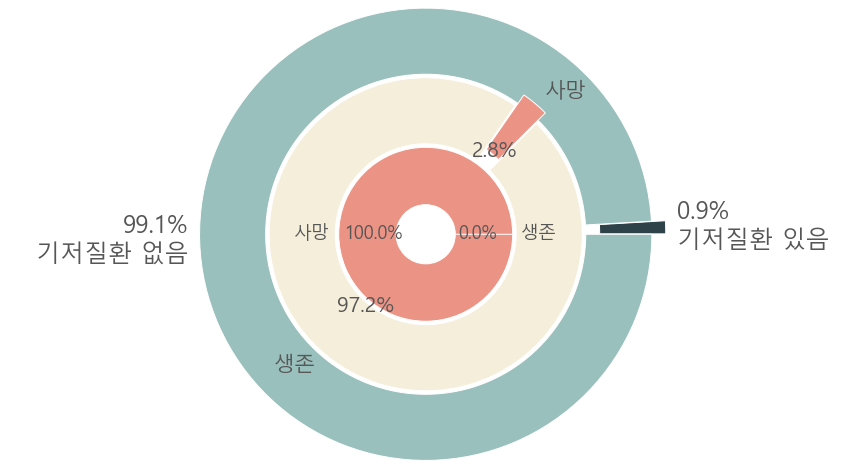

In [42]:
plt.rcParams['figure.figsize'] = [15, 8]
width_num = 0.4
fig, ax = plt.subplots()
ax.axis('equal')
x = disease_patient_ratio[1]
y = disease_patient_ratio[0]
pie_outside, _ = ax.pie(disease_patient_ratio, 
                        radius=1.3, 
                        labels=[
                            str(((y / x) * 100).round(1))+'%\n기저질환 있음', 
                            str(100-((y / x) * 100).round(1))+'%\n기저질환 없음'
                        ],
                        labeldistance=1.05,
                        shadow=False, 
                        explode=(0.08, 0),
                        colors=[palette[4], palette[2]],
                        textprops={'fontsize': 24, 'color': '#565656'})
plt.setp(pie_outside, 
         width=width_num-0.02, 
         edgecolor='white')
pie_inside, plt_labels, junk = \
    ax.pie(disease_false_ratio, 
           radius=(1.3 - width_num), 
           labels=['사망', '생존'], 
           labeldistance=1.1, 
           autopct='%1.1f%%', 
           explode=(0.08, 0),
           colors=[palette[0], palette[1]], 
           startangle=45,
           textprops={'fontsize': 21, 'color': '#565656'})
plt.setp(pie_inside, 
         width=width_num-0.02, 
         edgecolor='white')
pie_inside, plt_labels, junk = \
    ax.pie(disease_true_ratio, 
           radius=(1.3 - width_num-width_num), 
           labels=['사망', '생존'], 
           labeldistance=1.1, 
           autopct='%1.1f%%', 
           startangle=0,
           colors=[palette[0], palette[2]], 
           textprops={'fontsize': 18, 'color': '#565656'})
plt.setp(pie_inside, 
         width=width_num-0.07, 
         edgecolor='white')
plt.show()

## 4. 고령자들의 고위험장소 분류

위의 분석을 도합 하자면 코로나는 노년층, 그리고 기저질환을 가진 중-노년층 환자에게 치명적이다는 결론을 얻을 수 있습니다.


그래서 청년층과 중년층, 노년층 별로 환자들의 방문 장소 빈도수로 고령자들이 방문을 지양해야 할 고위험 장소를 분류해보았고,
노년층에겐 마트, 식당, 공항, 교회 총 4가지 구역이 고위험 장소로 분류되었습니다.

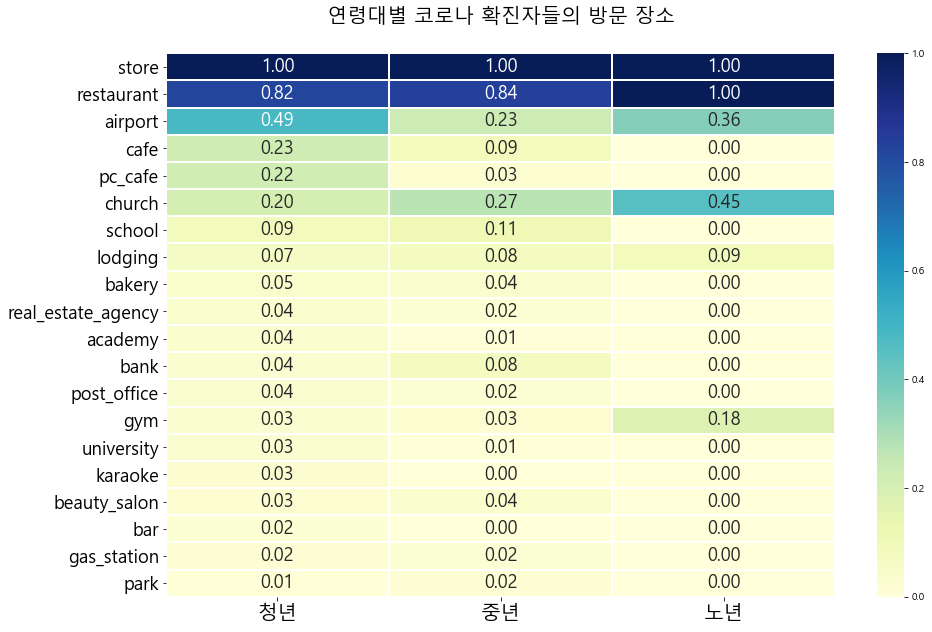

In [26]:
# 노인들의 이동경로와 청년들의 이동경로로 노인들에게 위험한 장소 분류

except_type = ['etc', 'hospital', 'pharmacy', 'administrative_area_level_1', 'public_transportation']

rute = pd.read_csv('./coronavirusdataset/PatientRoute.csv')
for i in except_type:
    rute = rute.drop(rute[rute.type == i].index, axis=0)

patient = ages[:]
rute_info = pd.merge(rute, patient[['patient_id', 'age', 'group', 'infection_case', 'infection_order', 'infected_by', 'contact_number']], on='patient_id')
rute_group_by_age = [rute_info[rute_info.group==x].type.value_counts() for x in ['청년', '중년', '노년']]

result = pd.DataFrame(rute_group_by_age).fillna(0)
result.index = ['청년', '중년', '노년']
result = result.T

plt.figure(figsize=(15, 10))
plt.title('연령대별 코로나 확진자들의 방문 장소\n', fontsize=20)
sns.heatmap(MaxAbsScaler().fit_transform(result), 
            annot=True, 
            fmt='.2f',
            cmap="YlGnBu",
            annot_kws={"size":18},
            linewidths=1)
plt.xticks(np.arange(len(result.columns))+0.5, ['청년', '중년', '노년'], fontsize=20)
plt.yticks(np.arange(len(result.index))+0.5, result.index, fontsize=18, rotation=0)
plt.show()